## Import Libraries

In [ ]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler

In [ ]:
torch.manual_seed(0)

## Load Data

In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"We're using => {device}")

data_dir = "car_bike_dataset"
print(f"data_dir: {data_dir}")

We're using => cpu
data_dir: car_bike_dataset


/home/mahmoud/.local/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


#### Define Transforms for train and test data

In [4]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

### Load train data and test data then split train data into train and val

In [5]:
train_dataset = datasets.ImageFolder(root=data_dir+"/train",
                                     transform=image_transforms["train"])
train_dataset

Dataset ImageFolder
    Number of datapoints: 3597
    Root location: car_bike_dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

##### Class <=> ID Mapping of Output

In [6]:
class_to_idx = train_dataset.class_to_idx
class_to_idx

{'Bike': 0, 'Car': 1}

In [7]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
idx_to_class

{0: 'Bike', 1: 'Car'}

### Get Train and Validation Samples

In [ ]:
# get the size of the train_dataset and indices
train_dataset_size = len(train_dataset)
train_dataset_indices = list(range(train_dataset_size))

In [ ]:
# shuffle the indices
np.random.shuffle(train_dataset_indices)

In [10]:
np.int32(0.2 * train_dataset_size)

719

In [11]:
val_split_index = int(np.int32(0.2 * train_dataset_size))

Train => val_split_index to n

Val => 0 to val_split_index

In [12]:
train_idx, val_idx = train_dataset_indices[val_split_index:], train_dataset_indices[:val_split_index]

In [13]:
len(train_idx), len(val_idx)

(2878, 719)

#### Load Test

In [14]:
test_dataset = datasets.ImageFolder(root=data_dir+"/test",
                                    transform=image_transforms["test"])
test_dataset

Dataset ImageFolder
    Number of datapoints: 400
    Root location: car_bike_dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
# use SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

### Train, Val and Test to DataLoader

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=train_sampler)
val_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=val_sampler)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

#### Show some Images

In [18]:
single_batch = next(iter(train_dataloader))
single_batch[0].shape, single_batch[1]

(torch.Size([32, 3, 224, 224]),
 tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
         0, 0, 1, 1, 0, 1, 1, 0]))

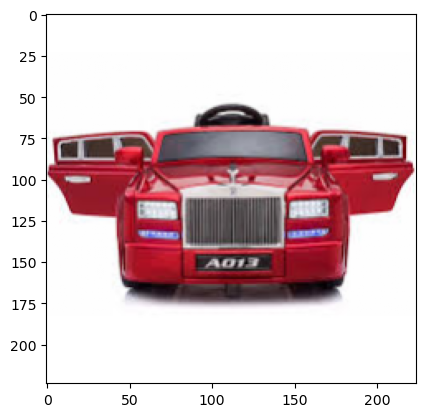

In [19]:
single_image = single_batch[0][0]
plt.imshow(single_image.permute(1,2,0))
plt.show()

In [20]:
classes = train_dataset.classes

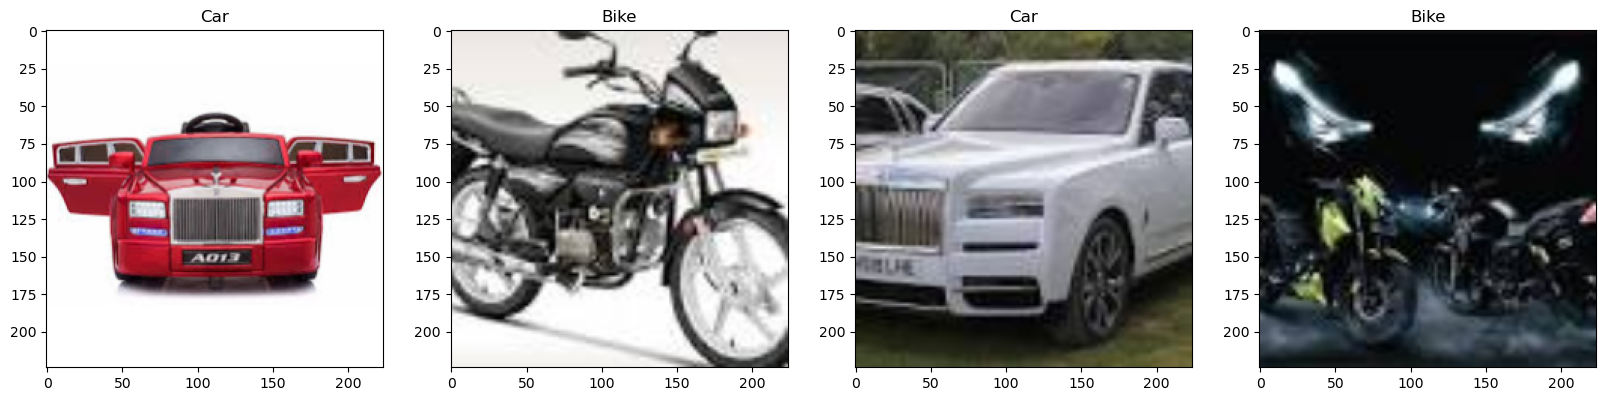

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(single_batch[0][:4]):
    ax[idx].imshow(img.permute(1, 2, 0))
    ax[idx].title.set_text(classes[single_batch[1][idx]])

## Build CNN Network

#### (CONV => RELU => POOL) * 2 => FC => RELU => FC

In [ ]:
class BinaryClassifierCNN(nn.Module):
    def __init__(self):
        super(BinaryClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=32 * 56 * 56, out_features=128)  
        self.fc2 = nn.Linear(in_features=128, out_features=1)
        # self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
model = BinaryClassifierCNN()
criterion = nn.BCEWithLogitsLoss()  # Use sigmoid with BCE
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Training and Validation loop Function

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure labels have the correct shape (N, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Get predictions
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)  # Ensure labels have the correct shape (N, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Get predictions
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Calculate accuracy
        train_accuracy = correct_train / total_train
        val_accuracy = correct_val / total_val

        # Print statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy*100:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy*100:.2f}%")

Epoch 1/4, Train Loss: 0.612143389052815, Val Loss: 0.37739941477775574
Epoch 2/4, Train Loss: 0.33581987255149415, Val Loss: 0.3034340894740561
Epoch 3/4, Train Loss: 0.22231122189097935, Val Loss: 0.2559789953672368
Epoch 4/4, Train Loss: 0.12361861161059803, Val Loss: 0.27022952942744544


### Test loop function

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).int()
            correct += (predictions.squeeze() == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {correct / total * 100:.2f}%")
test(model, test_dataloader)

/usr/lib/python3/dist-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 94.25%


### Save the model

In [ ]:
# Save model
# torch.save(model.state_dict(), 'binary_cnn_3.pth')


### Try on unseed data

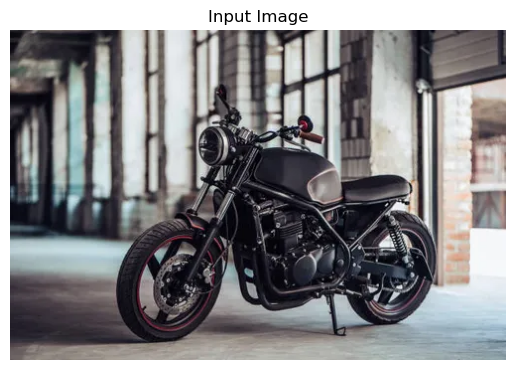

Prediction: Bike


In [44]:
import cv2
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# Read and resize the image
img = cv2.imread("test_imgs/bike_4.jpg")
# img_resized = cv2.resize(img, (224, 224))

# Convert BGR (OpenCV) to RGB (PyTorch expects RGB)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the resized image
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Input Image")
plt.show()

img_pil = Image.fromarray(img_rgb)

model.eval()
def predict(image, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    output = model(image)
    prediction = torch.sigmoid(output).item()
    return prediction > 0.5
# print(predict(img_pil, model))
result = predict(img_pil, model)
print(f"Prediction: {'Car' if result else 'Bike'}")



In [ ]:
# import torch
# correct_train = 0
# total_train = 0
# labels = torch.tensor([1])
# print(labels.size(0))
# predicted = (torch.sigmoid(torch.tensor([0.4])) > 0.5).float()
# predicted

# correct_train += (predicted == 1).sum().item()
# print(correct_train)
# total_train += labels.size(0)
# print(total_train)